# Processing PSD data from the NASA DAAC
Creates the files that have been provided in the GitHub repository
1) Read in data. Required data DOIs:
- 2DS and HVPS data: https://doi.org/10.5067/IMPACTS/PROBES/DATA101
- P3 Navigation Data: https://doi.org/10.5067/IMPACTS/P3/DATA101
2) Mask PSDs with bad quality and temperatures > 0 C
3) Averge PSDs over time interval (here 5 seconds)
4) Merge 2DS and HVPS data
5) Plotting final data as a check
6) Save file

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from datetime import timedelta
import pandas as pd
import icartt

In [ ]:
# Path specificies where the 2DS and HVPS files are located
path = ''
day = '20230129'

In [ ]:
if day=='20200125':
    lowtype='MB'
    region='NE'
    er2_fl=[['2020-01-25 19:20:00', '2020-01-25 19:32:00', '1'],
            ['2020-01-25 20:00:30', '2020-01-25 20:17:00', '2'],
            ['2020-01-25 20:32:00', '2020-01-25 20:50:00', '3'],
            ['2020-01-25 21:04:30', '2020-01-25 21:22:15', '4'],
            ['2020-01-25 21:36:00', '2020-01-25 21:54:00', '5'],
            ['2020-01-25 22:13:15', '2020-01-25 22:22:15', '6'], # Not great coordination in time
            ['2020-01-25 22:21:00', '2020-01-25 22:31:00', '7'],
            ['2020-01-25 22:43:30', '2020-01-25 22:58:00', '8']] # Not great coordination in time
    p3_fl= [['2020-01-25 19:21:00', '2020-01-25 19:33:00', '1'], # P3 above of cloud echo?
            ['2020-01-25 20:02:00', '2020-01-25 20:19:30', '2'], # No cloud echo?
            ['2020-01-25 20:34:00', '2020-01-25 20:49:30', '3'], # P3 in then OUT of cloud?
            ['2020-01-25 21:02:00', '2020-01-25 21:21:00', '4'], # P3 OUT then in cloud?
            ['2020-01-25 21:34:00', '2020-01-25 21:51:00', '5'],
            ['2020-01-25 22:05:15', '2020-01-25 22:13:30', '6'], # P3 at cloud top?
            ['2020-01-25 22:17:45', '2020-01-25 22:27:00', '7'],
            ['2020-01-25 22:45:00', '2020-01-25 23:03:00', '8']] # P3 OUT then in cloud?
    
if day=='20230129':
    lowtype='AF'
    region='NE'
    er2_fl=[['2023-01-29 14:53:45', '2023-01-29 15:15:00', '1'],
            ['2023-01-29 15:27:45', '2023-01-29 15:43:06', '2'],
            ['2023-01-29 15:55:30', '2023-01-29 16:13:00', '3'],
            ['2023-01-29 16:22:00', '2023-01-29 16:40:30', '4']]
    p3_fl= [['2023-01-29 14:46:15', '2023-01-29 15:18:15', '1'],
            ['2023-01-29 15:23:00', '2023-01-29 15:46:00', '2'],
            ['2023-01-29 15:51:00', '2023-01-29 16:13:30', '3'],
            ['2023-01-29 16:18:30', '2023-01-29 16:46:15', '4']]

### 1) 
- Read in data
- Masking data on quality flags and temperature
- Create datasets of 2DS/HVPS data with navigation data

In [ ]:
# Specifying 2D-S and HVPS files
file_2ds = path+'/IMPACTS_2DSV-P3_'+day+'_sizedistributions_v01.nc'
file_hvps = path+'/IMPACTS_HVPS3A-P3_'+day+'_sizedistributions_v01.nc'

In [ ]:
icartt_file = glob.glob('/IMPACTS_MetNav_P3B_'+day+'*.ict')[0]
ict = icartt.Dataset(icartt_file)

nav_time = [pd.to_datetime(day)+timedelta(seconds=ict.data['Time_Start'][i]) for i in range(len(ict.data['Time_Start']))]
nav_alt = ict.data['GPS_Altitude']
nav_lat = ict.data['Latitude']
nav_lon = ict.data['Longitude']
nav_temp = ict.data['Static_Air_Temp']

nav_ds = xr.Dataset({})
nav_ds = xr.Dataset(data_vars=dict(
        nav_alt=(["Time"], nav_alt),
        nav_lat=(["Time"], nav_lat),
        nav_lon=(["Time"], nav_lon),
        nav_temp=(["Time"], nav_temp)),
        coords=dict(Time=("Time", nav_time)))
nav_ds

/data/keeling/a/kheimes2/miniconda3/envs/scattering2/lib/python3.10/site-packages/icartt/dataset.py:392: UserWarning: Variable short name Dew/Frost_Point does not comply with ICARTT standard v2
  warnings.warn(
/data/keeling/a/kheimes2/miniconda3/envs/scattering2/lib/python3.10/site-packages/icartt/dataset.py:290: UserWarning: Normal comments: required keyword PLATFORM is missing.
  warnings.warn(
/data/keeling/a/kheimes2/miniconda3/envs/scattering2/lib/python3.10/site-packages/icartt/dataset.py:692: UserWarning: Number of header lines suggested in line 1 (76) do not match actual header lines read (77)
  warnings.warn(


<xarray.Dataset>
Dimensions:   (Time: 16604)
Coordinates:
  * Time      (Time) datetime64[ns] 2023-01-29T13:29:02 ... 2023-01-29T18:05:45
Data variables:
    nav_alt   (Time) float64 15.0 14.0 14.0 14.0 14.0 ... 14.0 14.0 14.0 14.0
    nav_lat   (Time) float64 37.93 37.93 37.93 37.93 ... 37.93 37.93 37.93 37.93
    nav_lon   (Time) float64 -75.47 -75.47 -75.47 ... -75.47 -75.47 -75.47
    nav_temp  (Time) float64 8.51 8.52 8.53 8.49 8.52 ... 14.25 14.4 14.5 14.65

In [6]:
# Opening 2DS and HVPS data
data_2ds = xr.open_dataset(file_2ds)
time_dates = [pd.to_datetime(data_2ds.attrs['FlightDate'])+timedelta(seconds=data_2ds.time.values[i]) for i in range(len(data_2ds.time.values))]
data_2ds = data_2ds.assign_coords(Time=("Time",time_dates))

data_hvps = xr.open_dataset(file_hvps)
time_dates = [pd.to_datetime(data_hvps.attrs['FlightDate'])+timedelta(seconds=data_hvps.time.values[i]) for i in range(len(data_hvps.time.values))]
data_hvps = data_hvps.assign_coords(Time=("Time",time_dates))

# Combine the navigation data and PSD data
data_2ds = xr.combine_by_coords([data_2ds, nav_ds], join='inner')
data_hvps = xr.combine_by_coords([data_hvps, nav_ds], join='inner')

# Masking PSDs with bad data and temperatures > 0C
mask = (data_2ds['PROBE_QC']==0)&(data_hvps['PROBE_QC']==0)&(data_2ds['nav_temp']<=0)
data_2ds = data_2ds.where(mask)
data_hvps = data_hvps.where(mask)

### 2) Averaging 2DS and HVPS PSDs and aspect ratios over a time period

In [7]:
# Function to calculate sample volume... will be needed to average data
def samp_vol_def(psd_data):
    bin_width_m = np.diff(psd_data.CONCENTRATION.attrs['bin_endpoints'])/10**6

    sampvol_ls = []
    for n in range(psd_data.Time.shape[0]):
        tot_part_num = psd_data.COUNTS.values[:,n].sum()
        tot_part_conc = (psd_data.CONCENTRATION.values[:,n]*bin_width_m).sum()
        samp_vol_val = tot_part_num/tot_part_conc
        sampvol_ls.append(samp_vol_val)
    sampvol = xr.DataArray(np.asarray(sampvol_ls), coords={'Time':psd_data.Time}, dims='Time')
    psd_data['Samp_Vol'] = sampvol
    psd_data = psd_data.assign_coords(bin_width=("bin_width",bin_width_m*10**6))
    psd_data['bin_width'].attrs['units'] = 'um'
    return(psd_data)

In [8]:
# Add sample volume to the dataset
data_2ds = samp_vol_def(data_2ds)
data_hvps = samp_vol_def(data_hvps)

/tmp/ipykernel_2713282/3035586324.py:9: RuntimeWarning: invalid value encountered in scalar divide
  samp_vol_val = tot_part_num/tot_part_conc


In [10]:
# Calculating average PSD and aspect ratio over a time interval
def avg_calc(psd_data, avg_interval):
    avg_5sec_idx = np.arange(0,psd_data.time.shape[0],avg_interval)

    avg_conc_da_ls=[]
    avg_ar_da_la = []
    time_ls = []
    for n in range(len(avg_5sec_idx)-1):
        counts_avg = psd_data.COUNTS[:,avg_5sec_idx[n]:avg_5sec_idx[n+1]].sum(axis=1)
        tot_sampvol_avg = np.ones(psd_data.COUNTS.shape[0])*psd_data.Samp_Vol[avg_5sec_idx[n]:avg_5sec_idx[n+1]].sum().values
        avg_concentration = (counts_avg/tot_sampvol_avg)*(1/(psd_data.bin_width.values/10**6))
        avg_conc_da_ls.append(avg_concentration)

        avg_ar_num = (psd_data.COUNTS*psd_data.MEAN_ASPECTRATIO)[:,avg_5sec_idx[n]:avg_5sec_idx[n+1]].sum(axis=1)
        tot_part = psd_data.COUNTS[:,avg_5sec_idx[n]:avg_5sec_idx[n+1]].sum(axis=1)
        avg_ar = avg_ar_num/tot_part
        avg_ar_da_la.append(avg_ar)

        time_ls.append(data_2ds.Time.values[avg_5sec_idx[n]:avg_5sec_idx[n+1]][2])
        
    avg_conc_da = xr.concat(avg_conc_da_ls, dim= "Time")
    avg_conc_da = avg_conc_da.assign_coords(Time=("Time",time_ls))

    avg_ar_da = xr.concat(avg_ar_da_la, dim= "Time")
    avg_ar_da = avg_ar_da.assign_coords(Time=("Time",time_ls))
    return(avg_conc_da, avg_ar_da)

In [11]:
# Calulate average PSDs and Aspect ratios for provided data and time interval
conc_2ds_avg, ar_2ds_avg = avg_calc(data_2ds, 5)
conc_hvps_avg, ar_hvps_avg = avg_calc(data_hvps, 5)

In [14]:
# Creating a dataset with averaged PSDs and aspect ratios
conc_2ds_avg_ds = conc_2ds_avg.to_dataset(name ='Average_CONC')
ar_2ds_avg_ds = ar_2ds_avg.to_dataset(name ='Average_ASPECTRATIO')
average_2ds = xr.merge([conc_2ds_avg_ds,ar_2ds_avg_ds])

conc_hvps_avg_ds = conc_hvps_avg.to_dataset(name ='Average_CONC')
ar_hvps_avg_ds = ar_hvps_avg.to_dataset(name ='Average_ASPECTRATIO')
average_hvps = xr.merge([conc_hvps_avg_ds,ar_hvps_avg_ds])

### 3) Merging 2DS and HVPS data

In [15]:
# Creating variables for HVPS PSD bins
mids_hvps = data_hvps.CONCENTRATION.attrs['bin_midpoints']
ends_hvps = data_hvps.CONCENTRATION.attrs['bin_endpoints']

# Add bin sizes as coordinates for the average PSD dataset
average_hvps = average_hvps.assign_coords({"Vector28":mids_hvps}).rename({"Vector28":"binmid"})

# Selecting HVPS bins to be combined with the 2DS
sub_hvps = average_hvps.sel(binmid=slice(1400,30000))
end_idx = np.where((mids_hvps > 1400)&(mids_hvps < 30000))[0]
ends_hvps = ends_hvps[end_idx[0]:]

In [16]:
# Creating variables for 2DS PSD bins
mids_2ds = data_2ds.CONCENTRATION.attrs['bin_midpoints']
ends_2ds = data_2ds.CONCENTRATION.attrs['bin_endpoints']

# Add bin sizes as coordinates for the average PSD dataset
average_2ds = average_2ds.assign_coords({"Vector23":mids_2ds}).rename({"Vector23":"binmid"})

# Selecting 2DS bins to be combined with the HVPS
sub_2ds = average_2ds.sel(binmid=slice(100,1400))
end_idx_2ds = np.where((mids_2ds > 100)&(mids_2ds < np.min(sub_hvps.binmid.values)))[0]
ends_2ds = ends_2ds[end_idx_2ds]

In [24]:
# Merge the 2DS and HVPS datasets
merged_avg_conc = xr.merge([sub_2ds, sub_hvps])
merged_avg_conc = merged_avg_conc.assign_coords({"binend":np.concatenate([ends_2ds,ends_hvps])})
merged_avg_conc['bin_width'] = np.diff(merged_avg_conc['binend'])
merged_avg_conc['bin_width'].attrs['units'] = 'um'
merged_avg_conc.attrs['bin_endpoints']=np.concatenate([ends_2ds,ends_hvps])
merged_avg_conc.attrs['bin_midpoints']=merged_avg_conc.binmid.values
merged_avg_conc = xr.merge([merged_avg_conc,nav_ds], join='left')

### 4) Plotting final (masked, merged, and averaged) PSDs and Aspect ratios

In [27]:
bw_2d = np.ones(merged_avg_conc.Average_CONC.shape)*merged_avg_conc.bin_width.values/10**6
bw_2d

array([[2.5e-05, 2.5e-05, 5.0e-05, ..., 2.0e-03, 5.0e-03, 5.0e-03],
       [2.5e-05, 2.5e-05, 5.0e-05, ..., 2.0e-03, 5.0e-03, 5.0e-03],
       [2.5e-05, 2.5e-05, 5.0e-05, ..., 2.0e-03, 5.0e-03, 5.0e-03],
       ...,
       [2.5e-05, 2.5e-05, 5.0e-05, ..., 2.0e-03, 5.0e-03, 5.0e-03],
       [2.5e-05, 2.5e-05, 5.0e-05, ..., 2.0e-03, 5.0e-03, 5.0e-03],
       [2.5e-05, 2.5e-05, 5.0e-05, ..., 2.0e-03, 5.0e-03, 5.0e-03]])

Text(0.5, 1.0, '5-Sec Average Concentration\n 2DS and HVPS Merged')

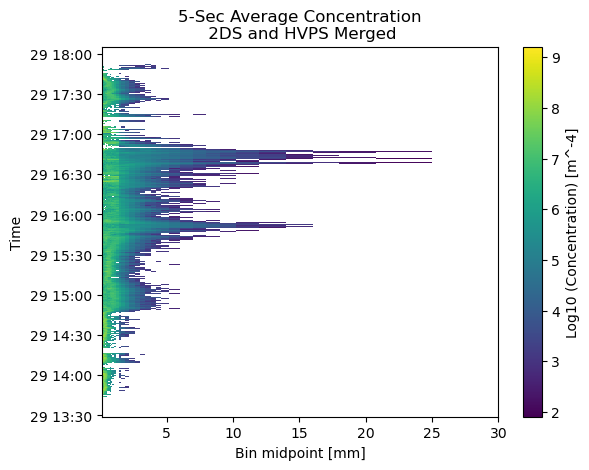

In [29]:
plt.pcolormesh(merged_avg_conc.Average_CONC.binmid/10**3, merged_avg_conc.Time, np.log10(merged_avg_conc.Average_CONC), cmap='viridis')
plt.colorbar(label='Log10 (Concentration) [m^-4]')
plt.xlabel('Bin midpoint [mm]')
plt.ylabel('Time')
plt.title('5-Sec Average Concentration\n 2DS and HVPS Merged')

Text(0.5, 1.0, 'Normalized 5-Sec Average Concentration by Bin Width\n 2DS and HVPS Merged')

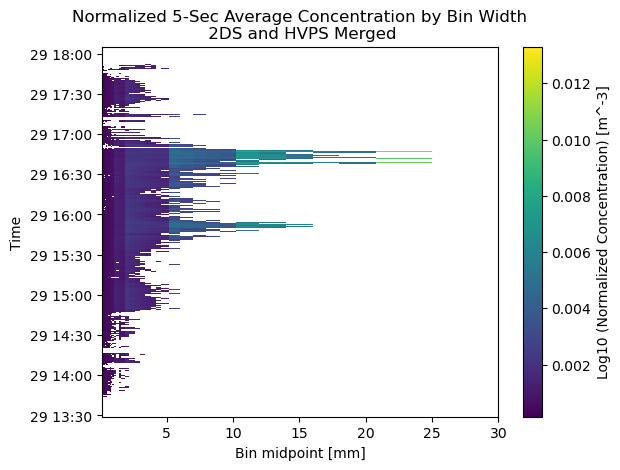

In [30]:
plt.pcolormesh(merged_avg_conc.Average_CONC.binmid/10**3, merged_avg_conc.Time, np.log10(merged_avg_conc.Average_CONC)*(bw_2d), cmap='viridis')
plt.colorbar(label='Log10 (Normalized Concentration) [m^-3]')
plt.xlabel('Bin midpoint [mm]')
plt.ylabel('Time')
plt.title('Normalized 5-Sec Average Concentration by Bin Width\n 2DS and HVPS Merged')


Text(0.5, 1.0, '5-Sec Average Average Aspect Ratio\n 2DS and HVPS Merged')

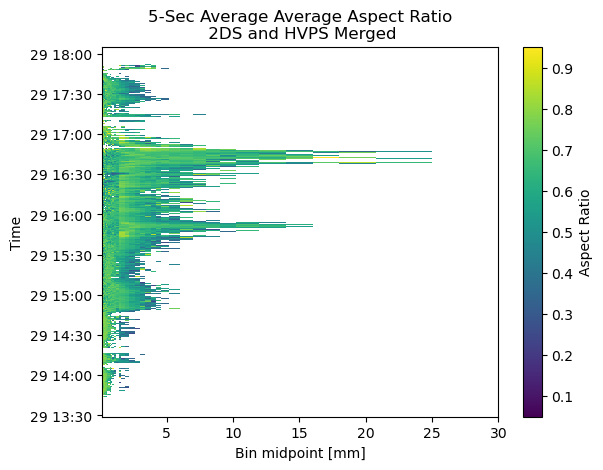

In [31]:
plt.pcolormesh(merged_avg_conc.Average_CONC.binmid/10**3, merged_avg_conc.Time, merged_avg_conc.Average_ASPECTRATIO, cmap='viridis')
plt.colorbar(label='Aspect Ratio')
plt.xlabel('Bin midpoint [mm]')
plt.ylabel('Time')
plt.title('5-Sec Average Average Aspect Ratio\n 2DS and HVPS Merged')

### 5) Save file

In [ ]:
merged_avg_conc.to_netcdf("merged_2DS_HVPS_5sec_avg_"+day+".nc")